In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
%qtconsole

# 9 Two Dimensions


## 9.1 Paintball

Paintball is a sport in which competing teams try to shoot each other
with guns that fire paint-filled pellets that break on impact, leaving a
colorful mark on the target. It is usually played in an arena decorated
with barriers and other objects that can be used as cover.

Suppose you are playing paintball in an indoor arena 30 feet wide and 50
feet long. You are standing near one of the 30 foot walls, and you
suspect that one of your opponents has taken cover nearby. Along the
wall, you see several paint spatters, all the same color, that you think
your opponent fired recently.

The spatters are at 15, 16, 18, and 21 feet, measured from the
lower-left corner of the room. Based on these data, where do you think
your opponent is hiding?

Figure [fig.paintball] shows a diagram of the arena. Using the
lower-left corner of the room as the origin, I denote the unknown
location of the shooter with coordinates $\alpha$ and $\beta$, or
`alpha` and `beta`. The location of a spatter is
labeled `x`. The angle the opponent shoots at is $\theta$ or
`theta`.

The Paintball problem is a modified version of the Lighthouse problem, a
common example of Bayesian analysis. My notation follows the
presentation of the problem in D.S. Sivia’s, *Data Analysis: a
Bayesian Tutorial, Second Edition* (Oxford, 2006).

## 9.2 The suite

![Diagram of the layout for the paintball problem.](figs/paintball.pdf)

[fig.paintball]

To get started, we need a set of hypotheses about the location
of the opponent. Each hypothesis is a pair of
coordinates $(\alpha, \beta)$. To get all possible coordinates
we define two arrays for the possible values of $\alpha$ and
$\beta$:

In [2]:
alphas = np.arange(0,31,dtype=float)
betas = np.arange(1,51,dtype=float)

Additionally we define an array `locations` which is a list of possible locations of a spatter along the wall; it is stored for the likelihood calculation. 

In [3]:
locations = np.arange(0,31,dtype=float)

The prior distribution assumes that all locations of 
the opponent in the room $(\alpha,\beta)$ are equally 
likely. Given a map of the room, we might choose a more detailed 
prior, but we’ll start simple.

In [4]:
prior = np.full(shape=(alphas.size,betas.size),fill_value=1/(alphas.size*betas.size))

`prior` is a 2D array filled with probabilities of the shooter beeing in particular a cell. Indexes `[i,j]` of each cell can be used to get the coordinates from 1D arrays `alphas[i]` and and `betas[j]`. 

## 9.3 Trigonometry

Now we need a likelihood function, which means we have to figure out the
likelihood of hitting any spot along the wall, given the location of the
opponent.

As a simple model, imagine that the opponent is like a rotating turret,
equally likely to shoot in any direction. In that case, he is most
likely to hit the wall at location `alpha`, and less likely
to hit the wall far away from `alpha`.

With a little trigonometry, we can compute the probability of hitting
any spot along the wall. Imagine that the shooter fires a shot at angle
$\theta$; the pellet would hit the wall at location $x$, where

$$x - \alpha = \beta \tan \theta$$ Solving this equation for $\theta$
yields $$\theta = tan^{-1} \left( \frac{x - \alpha}{\beta} \right)$$ 

So given a location on the wall, we can find $\theta$.

Taking the derivative of the first equation with respect to $\theta$
yields

$$\frac{dx}{d\theta} = \frac{\beta}{\cos^2 \theta}$$ 

This derivative is what I’ll call the “strafing speed”, which is the speed of
the target location along the wall as $\theta$ increases. The
probability of hitting a given point on the wall is inversely related to
strafing speed.

If we know the coordinates of the shooter and a location along the wall,
we can compute strafing speed:

In [5]:
def get_strafingspeed(alpha,beta,x):
    theta = np.arctan2(x-alpha,beta)
    speed = beta / np.cos(theta)**2
    return speed

`alpha` and `beta` are the coordinates of the
shooter; `x` is the location of a spatter. The result is the
derivative of `x` with respect to `theta`.

Now we can compute a PMF that represents the probability of hitting any lo-
cation on the wall. The function `make_pmf_location` takes `alphas` and `betas` , the coordinates
of the shooter, and `locations`, a list of possible values of x. The input variables can be scalar
or 1d arrays. Again, we use `meshgrid` inside the function to vectorize the calculations.

In [6]:
def make_pmf_location(alphas, betas, locations):
    mg_alphas, mg_betas, mg_locations = np.meshgrid(alphas,betas,locations, indexing = 'ij')
    speeds = get_strafingspeed(mg_alphas,mg_betas,mg_locations)
    location_pmfs = np.ones_like(speeds) / speeds
    #normalize along location axis
    location_pmfs = location_pmfs / location_pmfs.sum(axis=2)[:,:,None]
    return location_pmfs

`make_pmf_location` computes the probability of hitting each location, which
is inversely related to strafing speed. The result is a PMF of locations and
their probabilities for all combinations of the provided `alphas` and `betas`.

Figure 9.3 shows the PMF of location with `alpha = 10` and a range of 
values for `beta`. For all values of beta the most likely spatter 
location is `x = 10`; as `beta` increases, so does the spread of the PMF.

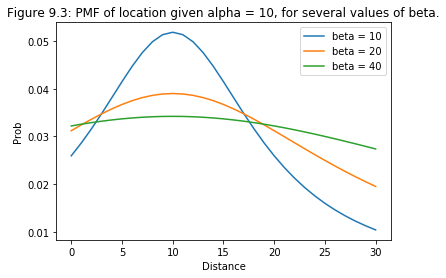

In [7]:
#Figure 9.3
pmfs_location_pk = make_pmf_location(alphas=10, betas=[10,20,40],locations=locations)
plt.plot(locations, pmfs_location_pk[0,0,:], label = 'beta = 10')
plt.plot(locations, pmfs_location_pk[0,1,:], label = 'beta = 20')
plt.plot(locations, pmfs_location_pk[0,2,:], label = 'beta = 40')

plt.xlabel('Distance');
plt.ylabel('Prob');
plt.legend()
plt.title('Figure 9.3: PMF of location given alpha = 10, for several values of beta.');

## 9.4 Likelihood

Now all we need is a way to calculate likelihood of a spatter being observed 
at a certain location for all $(\alpha,\beta)$ coordinates. This boils down
to getting the probability value from location PMF corresponding to the spatter 
location value $x$ for for all $(\alpha,\beta)$ coordinates. This can be done 
by using the `make_pmf_location` function providing all possible values of `alphas`
and `betas` and `locations` and then making a slice of the output corresponding 
to the `observed_locations`. 

In [8]:
observed_locations = np.array([15,16,18,21])

location_pmfs = make_pmf_location(alphas, betas, locations)
likelihoods = location_pmfs[:,:,observed_locations]

And we’re done. Now we can update the prior with the 
observed locations of spatters to get the posterior distribution.

In [9]:
posterior = prior * likelihoods.prod(axis=2)
posterior /= posterior.sum()

The result is a posterior distribution that maps each `(alpha, beta)`
pair to a posterior probability.

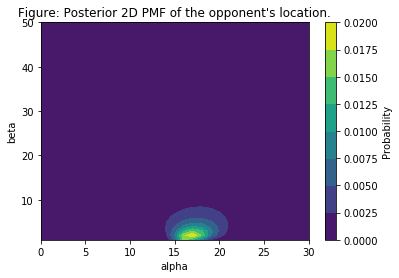

In [10]:
#Figure not in the original
plt.contourf(alphas,betas,posterior.T)
plt.colorbar(label='Probability')

plt.xlabel('alpha');
plt.ylabel('beta');
plt.title("Figure: Posterior 2D PMF of the opponent's location.");

## 9.5 Joint distributions

When each value in a distribution is a tuple of variables, it is called
a **joint distribution** because it represents the
distributions of the variables together, that is “jointly”. A joint
distribution contains the distributions of the variables, as well
information about the relationships among them.

Given a joint distribution, we can compute the distributions of each
variable independently, which are called the **marginal
distributions**. Here’s the code that extracts the marginal distributions:

In [11]:
cdf_alpha_marginal_pk = posterior.sum(axis=1).cumsum()
cdf_beta_marginal_pk = posterior.sum(axis=0).cumsum()

Figure 9.2 shows the results (converted to CDFs).

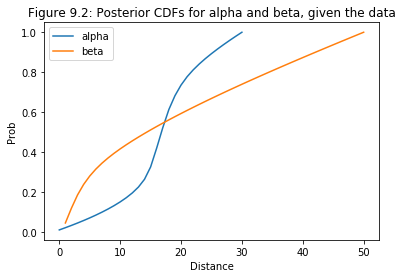

In [12]:
#Figure 9.2
plt.plot(alphas,cdf_alpha_marginal_pk,label="alpha")
plt.plot(betas,cdf_beta_marginal_pk,label="beta")

plt.xlabel('Distance');
plt.ylabel('Prob');
plt.legend()
plt.title('Figure 9.2: Posterior CDFs for alpha and beta, given the data');

The median value for `alpha` is 17 (Note median in the book is  in the book is 18), near the center of mass of
the observed spatters. For `beta`, the most likely values are
close to the wall, but beyond 10 feet the distribution is almost
uniform, which indicates that the data do not distinguish strongly
between these possible locations.

In [13]:
idx=np.argmax(cdf_alpha_marginal_pk>=0.5)
print(f"median = {alphas[idx]:2.0f}")

median = 17


Given the posterior marginals, we can compute credible intervals for
each coordinate independently:

In [14]:
print([alphas[1:][np.argmax(cdf_alpha_marginal_pk>=0.25)-1], alphas[1:][np.argmax(cdf_alpha_marginal_pk>=0.75)-1]])
print([ betas[1:][np.argmax(cdf_beta_marginal_pk>=0.25)-1],   betas[1:][np.argmax(cdf_beta_marginal_pk>=0.75)-1]])

[14.0, 21.0]
[5.0, 31.0]


The 50% credible intervals are `(14, 21)` for
`alpha` and `(5, 31)` for `beta`. So
the data provide evidence that the shooter is in the near side of the
room. But it is not strong evidence. The 90% credible intervals cover
most of the room!

In [15]:
print([alphas[1:][np.argmax(cdf_alpha_marginal_pk>=0.05)-1], alphas[1:][np.argmax(cdf_alpha_marginal_pk>=0.95)-1]])
print([ betas[1:][np.argmax(cdf_beta_marginal_pk>=0.05)-1],   betas[1:][np.argmax(cdf_beta_marginal_pk>=0.95)-1]])

[4.0, 28.0]
[2.0, 47.0]


## 9.6 Conditional distributions

The marginal distributions contain information about the variables
independently, but they do not capture the dependence between variables,
if any.

One way to visualize dependence is by computing **conditional
distributions** i.e. a distribution of the $i$th variable under the condition
that the $j$th variable has a certain value.

For example, the following code computes the conditional distributions
of `alpha` for a range of values of `beta=[10,20,40]`:

In [16]:
idx_betas = np.searchsorted(betas,[10,20,40])
pmf_betas_conditional_pk = posterior[:,idx_betas]
pmf_betas_conditional_pk/= pmf_betas_conditional_pk.sum(axis=0)

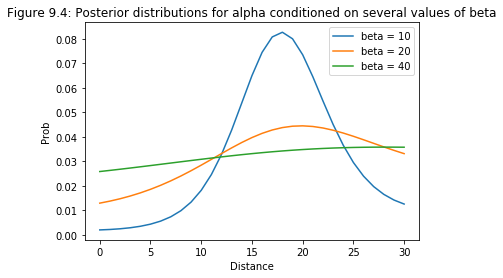

In [17]:
#Figure 9.4
plt.plot(alphas,pmf_betas_conditional_pk[:,0],label='beta = 10')
plt.plot(alphas,pmf_betas_conditional_pk[:,1],label='beta = 20')
plt.plot(alphas,pmf_betas_conditional_pk[:,2],label='beta = 40')

plt.xlabel('Distance');
plt.ylabel('Prob');
plt.legend()
plt.title('Figure 9.4: Posterior distributions for alpha conditioned on several values of beta');

Figure 9.4 shows the results, which we could fully describe
as “posterior conditional marginal distributions.” Whew!

If the variables were independent, the conditional distributions would
all be the same. Since they are all different, we can tell the variables
are dependent. For example, if we know (somehow) that `beta = 10`, the
conditional distribution of `alpha` is fairly
narrow. For larger values of `beta`, the distribution of
`alpha` is wider.

## 9.7 Credible intervals

Another way to visualize the posterior joint distribution is to compute
credible intervals. When we looked at credible intervals in
Section 3.5, I skipped over a subtle point: for a given
distribution, there are many intervals with the same level of
credibility. For example, if you want a 50% credible interval, you could
choose any set of values whose probability adds up to 50%.

When the values are one-dimensional, it is most common to choose the
**central credible interval**; for example, the central 50%
credible interval contains all values between the 25th and 75th
percentiles.

In multiple dimensions it is less obvious what the right credible
interval should be. The best choice might depend on context, but one
common choice is the maximum likelihood credible interval, which
contains the most likely values that add up to 50% (or some other
percentage).

Below is an approach to compute maximum likelihood credible intervals:

In [88]:
posterior_flat = posterior.flatten()
idx_sort=np.argsort(posterior_flat)
idx_original = np.argsort(idx_sort)
m = np.zeros_like(posterior_flat)

posterior_flat=posterior_flat[idx_sort].cumsum()
ci = np.array([0, 0.25, 0.50, 0.75 ,1.0 ])

for i in range(confidence_intervals.size-1):
    idx = np.logical_and((ci[i]<posterior_flat),(posterior_flat<=ci[i+1]+0.00001))
    m[idx]=100-ci[i]*100

m=m[idx_original].reshape(posterior.shape)

The first step is to flaten the 2d posterior distribution and sort the 
values in ascending order by probability and calculate their cumulative sum.
Next we find indexes of the values for the corresponding confidence intervals
and construct an auxiliary array `m` for cisualization. Finally, we reorder and 
reshape `m` so that is corresponds to `posterior`.

Figure 9.5 visualizes the intervals. The 25% credible interval is
the darkest region near the bottom wall. For higher percentages, the
credible interval is bigger, of course, and skewed toward the right side
of the room.

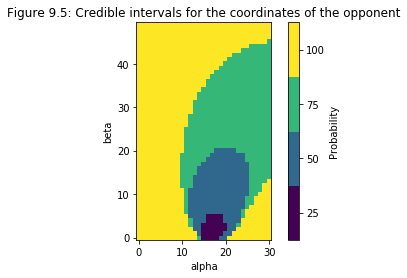

In [87]:
#Figure 9.5
cmap = plt.get_cmap('viridis', 4) 
ticks=np.array([18.75/2, 18.75, 18.75, 18.75]).cumsum()+25

plt.imshow(m.T,origin='lower', cmap=cmap)
cbar=plt.colorbar(label='Probability',ticks=ticks)
cbar.ax.set_yticklabels(['25', '50', '75','100'])

plt.xlabel('alpha');
plt.ylabel('beta');
plt.title('Figure 9.5: Credible intervals for the coordinates of the opponent');

## 9.8 Discussion

This chapter shows that the Bayesian framework from the previous
chapters can be extended to handle a two-dimensional parameter space.
The only difference is that each hypothesis is represented by a tuple of
parameters.

I also presented how to calculate `Marginal` and `Conditional` 
distributions.

There is a lot of new vocabulary in this chapter, so let’s review:

Joint distribution:
    A distribution that represents all possible values in a
    multidimensional space and their probabilities. The example in this
    chapter is a two-dimensional space made up of the coordinates
    `alpha` and `beta`. The joint distribution
    represents the probability of each (`alpha`,
    `beta`) pair.

Marginal distribution:
:   The distribution of one parameter in a joint distribution, treating
    the other parameters as unknown. For example,
    Figure 9.2 shows the distributions of
    `alpha` and `beta` independently.

Conditional distribution:
:   The distribution of one parameter in a joint distribution,
    conditioned on one or more of the other parameters.
    Figure 9.4 several distributions for
    `alpha`, conditioned on different values of
    `beta`.

Given the joint distribution, you can compute marginal and conditional
distributions. With enough conditional distributions, you could
re-create the joint distribution, at least approximately. But given the
marginal distributions you cannot re-create the joint distribution
because you have lost information about the dependence between
variables.

If there are $n$ possible values for each of two parameters, most
operations on the joint distribution take time proportional to $n^2$. If
there are $d$ parameters, run time is proportional to $n^d$, which
quickly becomes impractical as the number of dimensions increases.

If you can process a million hypotheses in a reasonable amount of time,
you could handle two dimensions with 1000 values for each parameter, or
three dimensions with 100 values each, or six dimensions with 10 values
each.

If you need more dimensions, or more values per dimension, there are
optimizations you can try. I present an example in Chapter 15.

## 9.9 Exercises

In our simple model, the opponent is equally likely to shoot in any
direction. As an exercise, let’s consider improvements to this model.

The analysis in this chapter suggests that a shooter is most likely to
hit the closest wall. But in reality, if the opponent is close to a
wall, he is unlikely to shoot at the wall because he is unlikely to see
a target between himself and the wall.

Design an improved model that takes this behavior into account. Try to
find a model that is more realistic, but not too complicated.